In [161]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import time
from scipy.signal import wiener
import asyncio

In [169]:
path = os.path.abspath("")
obj = 'vert'
fileFolderPath = f'{path}\\..\\{obj}\\{obj}'
filePath = os.path.normpath(f'{fileFolderPath}.jpg')
print(filePath)
image = mpimg.imread(filePath)
#image = cv2.imread(filePath,  0)

c:\Users\rss\uni\python-denoise\vert\vert.jpg


In [79]:
def show_img(complex_image):
    magnitude_image = np.abs(complex_image)

    # Step 2: Normalize the image to range [0, 255] for displaying with OpenCV
    normalized_image = cv2.normalize(magnitude_image, None, 0, 255, cv2.NORM_MINMAX)

    # Convert to uint8 (optional, but necessary for cv2.imshow)
    display_image = np.uint8(normalized_image)

    # Step 3: Display the image
    cv2.imshow('Magnitude Image', display_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [177]:
def fft_denoise_channel(image, k=4, l=10, frequency=5):
    f_transform = np.fft.fft2(image)
    center_shift = np.fft.fftshift(f_transform)

    #show_img(f_transform)
    #show_img(center_shift)

    rows, cols = 0, 0
    if len(image.shape) == 3:
        rows, cols, _ = image.shape
    else:
        rows, cols = image.shape
    
    crow, ccol = rows // 2, cols // 2

    noise_frequency = int(frequency * cols / rows)

    #center_shift[crow - k:crow + k, 0:ccol - l] = 1
    #center_shift[crow - k:crow + k, ccol + l:] = 1

    center_shift[crow - k:crow + k, ccol - noise_frequency - l:ccol - noise_frequency + l] = 1
    center_shift[crow - k:crow + k, ccol + noise_frequency - l:ccol + noise_frequency + l] = 1

    #center_shift[crow - k:crow + k, :] = 0

    f_shift = np.fft.ifftshift(center_shift)
    denoised_image = np.abs(np.fft.ifft2(f_shift))
    return np.clip(denoised_image, 0, 255).astype(np.uint8)

In [178]:
def fft_denoise(image, k, l, frequency):
    return cv2.merge([fft_denoise_channel(channel, k, l, frequency) for channel in cv2.split(image)])

In [36]:
def plot_images(noised, denoised):
    rmse1 = np.sqrt(np.mean((noised - denoised) ** 2))

    images = [
        noised, denoised, cv2.absdiff(noised, denoised)
    ]
    image_titles = [
        'Noised RGB image',
        'Denoised RGB image',
        f'Difference between noised and denoised RGB images\n RMSE: {rmse1:.3f}'
    ]

    num_rows = 1
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()

    for i, (image, title) in enumerate(zip(images, image_titles)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(title, fontsize=12)  # Set the title
        axes[i].axis('off')  # Hide axes ticks and labels

    # If there are empty subplots, turn off the axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    # Show the plot
    plt.tight_layout()
    #plt.savefig(f'{filePath}-comparison-plot.png', format='png', dpi=600)
    plt.show()

In [37]:
def plot_performance():
    times = []

    for x in range(100):

        start = time.time()

        fft_denoise(noised, k=2, l=2, frequency=5)

        times.append(time.time() - start)

    mean = np.mean(times)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(range(100), times, marker='o', label = "Iterations execution time")
    plt.plot(range(100), [mean for x in range(100)], marker='o', label = "Mean execution time")
    plt.title('Landscape Denoising Execution Time')
    plt.xlabel('Iteration')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    #plt.savefig(f'{filePath}-performance-plot.png', format='png', dpi=600)
    plt.show()

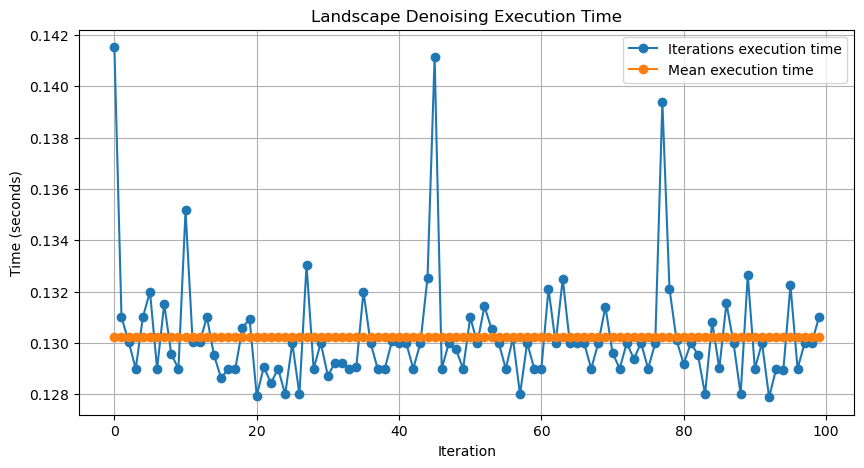

In [38]:
plot_performance()

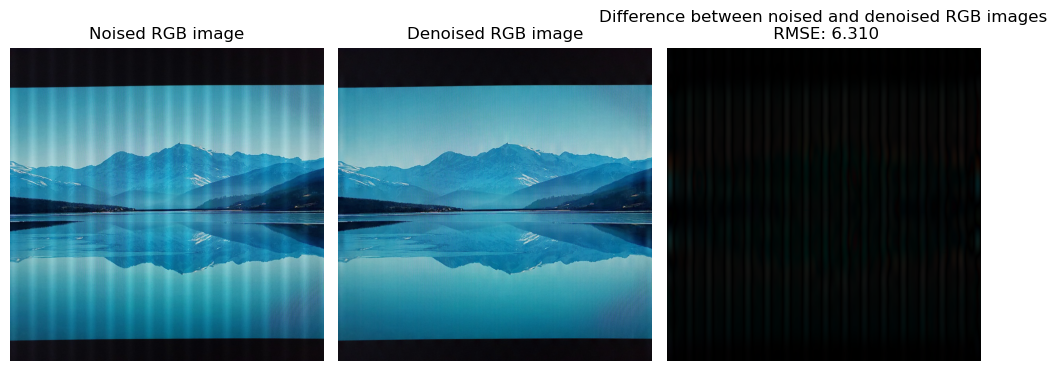

In [182]:
noised = image
denoised = fft_denoise(noised, k=11, l=11, frequency=25)
plot_images(noised, denoised)